In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sklearn.feature_extraction.text
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
from sklearn import preprocessing
import re
import string

import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tqdm import tqdm

plt.ioff()
pd.set_option('display.max_columns', None)

Using TensorFlow backend.


## Download data from https://www.kaggle.com/mczielinski/bitcoin-historical-data/data

In [2]:
data_frame = pd.read_csv('data/coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv.csv')

In [3]:
data_frame.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
1459071,1508457360,5700.01,5700.01,5700.00,5700.01,4.107598,23413.350886,5700.009878
1459072,1508457420,5700.01,5700.54,5700.01,5700.54,3.377075,19250.702466,5700.407366
1459073,1508457480,5700.54,5704.01,5700.53,5704.01,5.572255,31770.431877,5701.539951
1459074,1508457540,5703.96,5704.01,5702.87,5704.01,2.489754,14200.042922,5703.392752
1459075,1508457600,5704.00,5704.01,5704.00,5704.01,1.700455,9699.411610,5704.009412


In [4]:
prices = data_frame['Weighted_Price']
prices = np.array(prices[-500000:])

<IPython.core.display.Javascript object>


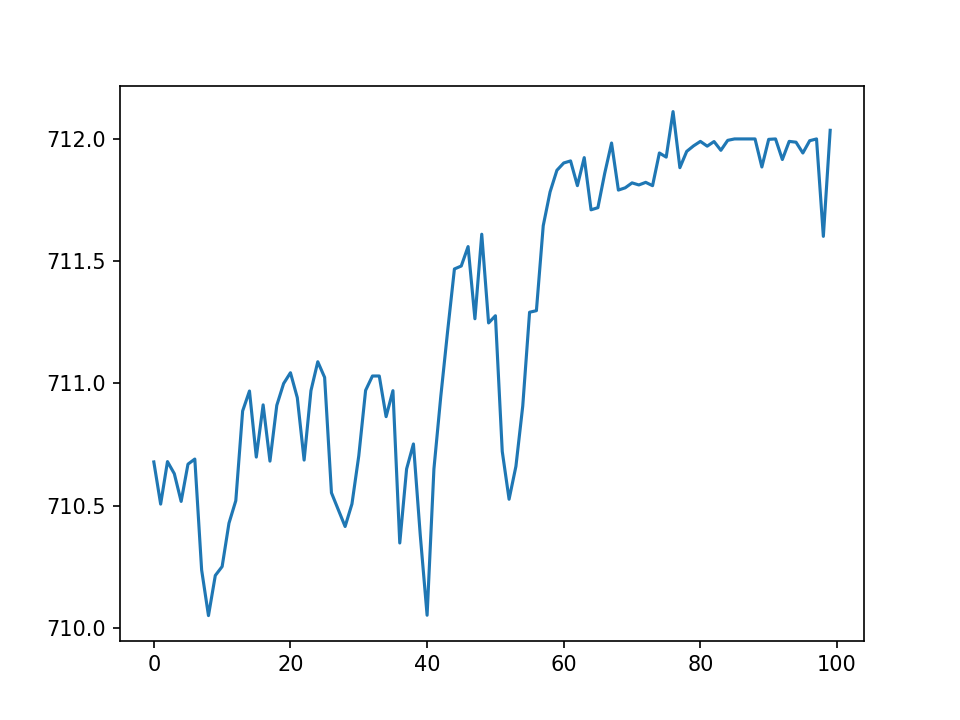

In [5]:
plt.plot(prices[0:100])
plt.show()

In [6]:
X = []
y = []
context_length = 50
gap = 10
for dt in tqdm(range(context_length+1, len(prices)-gap, gap)):
    input_prices = prices[dt-context_length:dt]
    input_percent_change = [[1e5*(prices[dt]-prices[dt-1])/(prices[dt-1])] for dt in range(dt-context_length, dt)]
    price_now = prices[dt+gap]
    percent_change_since_last_knowledge = (input_prices[-1]-price_now)/input_prices[-1]
    is_change_positive = [1, 0] if percent_change_since_last_knowledge > 0 else [0, 1]
    X.append(input_percent_change)
    y.append(is_change_positive)
    
X = np.array(X)
# X = X.reshape((len(X), 1, 100))
y = np.array(y)

100%|██████████| 49994/49994 [00:05<00:00, 9270.22it/s] 


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4., random_state=1)
print(X_train.shape)
print(y_train.shape)

(37495, 50, 1)
(37495, 2)


In [ ]:
print(X_train[0:])

In [8]:
plt.plot(X[0:50])
plt.show()

ValueError: x and y can be no greater than 2-D, but have shapes (50,) and (50, 50, 1)

In [9]:
# embedding_vector_length = 64
model = Sequential()
# model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(128, input_shape=(context_length, 1)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, nb_epoch=5, batch_size=64,  validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 66,818
Trainable params: 66,818
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python2.7/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 37495 samples, validate on 12499 samples
Epoch 1/5
37495/37495 [==============================] - 87s - loss: 0.6880 - acc: 0.5477 - val_loss: 0.6899 - val_acc: 0.5260
Epoch 2/5
37495/37495 [==============================] - 88s - loss: 0.6840 - acc: 0.5553 - val_loss: 0.6853 - val_acc: 0.5493
Epoch 3/5
37495/37495 [==============================] - 73s - loss: 0.6827 - acc: 0.5566 - val_loss: 0.6862 - val_acc: 0.5435
Epoch 4/5
37495/37495 [==============================] - 72s - loss: 0.6818 - acc: 0.5618 - val_loss: 0.6835 - val_acc: 0.5588
Epoch 5/5
37495/37495 [==============================] - 72s - loss: 0.6799 - acc: 0.5660 - val_loss: 0.6862 - val_acc: 0.5540


In [ ]:
# Final evaluation of the model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred_class = np.argmax(y_train_pred, axis=1)
y_test_pred_class = np.argmax(y_test_pred, axis=1)
y_train_class = np.argmax(y_train, axis=1)
y_test_class = np.argmax(y_test, axis=1)

train_accuracy = sklearn.metrics.accuracy_score(y_train_class, y_train_pred_class)
test_accuracy = sklearn.metrics.accuracy_score(y_test_class, y_test_pred_class)
print("Train Accuracy {}%".format(train_accuracy*100.0))
print("Test Accuracy {}%".format(test_accuracy*100))

cf_matrix = confusion_matrix(y_test_class, y_test_pred_class)
print("Confusion Matrix")
print(cf_matrix)